In [49]:
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import numpy as np # linear algebra
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

## Loading data

In [7]:
data=pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [9]:
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

<AxesSubplot:xlabel='Churn', ylabel='Count'>

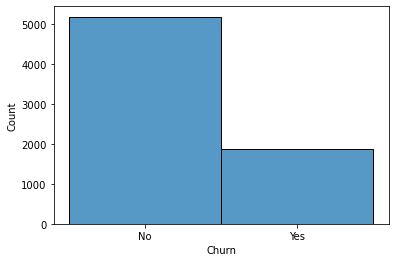

In [13]:
sns.histplot(data=data, x="Churn")

In [14]:
df = data.drop(['customerID'],axis=1)

In [16]:
df = df[df.TotalCharges!=' ']

In [17]:
df.TotalCharges = pd.to_numeric(df.TotalCharges)

<AxesSubplot:xlabel='MonthlyCharges', ylabel='Count'>

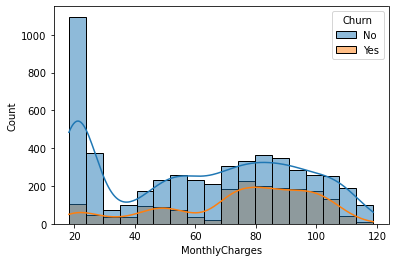

In [18]:
sns.histplot(data=data,x='MonthlyCharges',hue='Churn',kde=True)

<AxesSubplot:xlabel='Contract'>

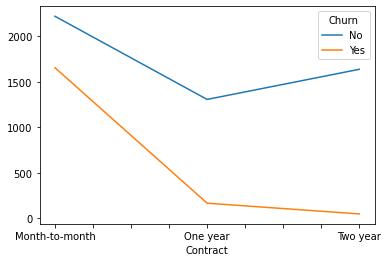

In [19]:
pd.crosstab(df.Contract,df.Churn).plot()

In [20]:
df.replace('No internet service','No',inplace=True)

In [21]:
df.MultipleLines.value_counts()
df.replace('No phone service','No',inplace=True)

In [22]:
df.MultipleLines.value_counts()

No     4065
Yes    2967
Name: MultipleLines, dtype: int64

In [23]:
df.gender = df.gender.replace({'Male':1,'Female':0})

In [24]:
cat_cols = ['Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity','OnlineBackup',
            'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling','Churn']

In [25]:
df[cat_cols] = df[cat_cols].replace({'Yes':1,'No':0})

In [26]:
df = pd.get_dummies(df,drop_first=True,dtype='uint')

In [27]:
num_cols = ['tenure','MonthlyCharges','TotalCharges']

In [32]:
mn = MinMaxScaler()
df[num_cols] = mn.fit_transform(df[num_cols])

In [33]:
X = df.drop('Churn',axis=1)
y = df.Churn

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [35]:
from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"

client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

In [36]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("Telco-churn-prediction")

2024/07/22 08:12:50 INFO mlflow.tracking.fluent: Experiment with name 'Telco-churn-prediction' does not exist. Creating a new experiment.


<Experiment: artifact_location='/workspaces/Telco-churn-prediction/model_training/mlruns/1', creation_time=1721635970217, experiment_id='1', last_update_time=1721635970217, lifecycle_stage='active', name='Telco-churn-prediction', tags={}>

In [58]:
len(y_train)

5625

In [37]:
xgb1 = xgb.XGBClassifier()

# Define the parameter grid
param_grid = {'tree_method': ['exact','approx','hist'],
              'n_estimators': range(5, 15),
              'max_depth': range(2,8),
              'booster': ['gbtree', 'gblinear','dart'],
              'n_jobs': range(5, 15)}

In [79]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_test, label=y_test)

def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
        mlflow.sklearn.log_model(xgb, artifact_path="models_mlflow")
        return {'loss': rmse, 'status': STATUS_OK}

In [75]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

In [80]:
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[0]	validation-rmse:0.42864                                                                                                                                                                           
[1]	validation-rmse:0.41576                                                                                                                                                                           
[2]	validation-rmse:0.40585                                                                                                                                                                           
[3]	validation-rmse:0.39978                                                                                                                                                                           
[4]	validation-rmse:0.39348                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.39624                                                                                                                                                                          
[42]	validation-rmse:0.39657                                                                                                                                                                          
[43]	validation-rmse:0.39699                                                                                                                                                                          
[44]	validation-rmse:0.39740                                                                                                                                                                          
[45]	validation-rmse:0.39767                                                                                                                                                                          
[46]	

2024/07/22 08:53:57 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!

2024/07/22 08:53:59 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp4h2o9v6m/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.0.2', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 



[0]	validation-rmse:0.42674                                                                                                                                                                           
[1]	validation-rmse:0.41477                                                                                                                                                                           
[2]	validation-rmse:0.40562                                                                                                                                                                           
[3]	validation-rmse:0.39986                                                                                                                                                                           
[4]	validation-rmse:0.39422                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.40310                                                                                                                                                                          
[42]	validation-rmse:0.40321                                                                                                                                                                          
[43]	validation-rmse:0.40332                                                                                                                                                                          
[44]	validation-rmse:0.40326                                                                                                                                                                          
[45]	validation-rmse:0.40330                                                                                                                                                                          
[46]	

2024/07/22 08:54:01 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.43821                                                                                                                                                                           
[1]	validation-rmse:0.43115                                                                                                                                                                           
[2]	validation-rmse:0.42500                                                                                                                                                                           
[3]	validation-rmse:0.41983                                                                                                                                                                           
[4]	validation-rmse:0.41563                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.39052                                                                                                                                                                          
[42]	validation-rmse:0.39091                                                                                                                                                                          
[43]	validation-rmse:0.39115                                                                                                                                                                          
[44]	validation-rmse:0.39148                                                                                                                                                                          
[45]	validation-rmse:0.39186                                                                                                                                                                          
[46]	

2024/07/22 08:54:04 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.43441                                                                                                                                                                           
[1]	validation-rmse:0.42517                                                                                                                                                                           
[2]	validation-rmse:0.41735                                                                                                                                                                           
[3]	validation-rmse:0.41119                                                                                                                                                                           
[4]	validation-rmse:0.40622                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.39717                                                                                                                                                                          
[42]	validation-rmse:0.39748                                                                                                                                                                          
[43]	validation-rmse:0.39762                                                                                                                                                                          
[44]	validation-rmse:0.39776                                                                                                                                                                          
[45]	validation-rmse:0.39811                                                                                                                                                                          
[46]	

2024/07/22 08:54:06 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.42699                                                                                                                                                                           
[1]	validation-rmse:0.41249                                                                                                                                                                           
[2]	validation-rmse:0.40109                                                                                                                                                                           
[3]	validation-rmse:0.39387                                                                                                                                                                           
[4]	validation-rmse:0.38836                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.38166                                                                                                                                                                          
[42]	validation-rmse:0.38159                                                                                                                                                                          
[43]	validation-rmse:0.38193                                                                                                                                                                          
[44]	validation-rmse:0.38232                                                                                                                                                                          
[45]	validation-rmse:0.38285                                                                                                                                                                          
[46]	

2024/07/22 08:54:09 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.42590                                                                                                                                                                           
[1]	validation-rmse:0.41065                                                                                                                                                                           
[2]	validation-rmse:0.39917                                                                                                                                                                           
[3]	validation-rmse:0.39146                                                                                                                                                                           
[4]	validation-rmse:0.38440                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.37686                                                                                                                                                                          
[42]	validation-rmse:0.37709                                                                                                                                                                          
[43]	validation-rmse:0.37732                                                                                                                                                                          
[44]	validation-rmse:0.37760                                                                                                                                                                          
[45]	validation-rmse:0.37784                                                                                                                                                                          
[46]	

2024/07/22 08:54:11 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.42770                                                                                                                                                                           
[1]	validation-rmse:0.41569                                                                                                                                                                           
[2]	validation-rmse:0.40575                                                                                                                                                                           
[3]	validation-rmse:0.40025                                                                                                                                                                           
[4]	validation-rmse:0.39630                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.40780                                                                                                                                                                          
[42]	validation-rmse:0.40800                                                                                                                                                                          
[43]	validation-rmse:0.40812                                                                                                                                                                          
[44]	validation-rmse:0.40845                                                                                                                                                                          
[45]	validation-rmse:0.40853                                                                                                                                                                          
[46]	

2024/07/22 08:54:14 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.43084                                                                                                                                                                           
[1]	validation-rmse:0.42116                                                                                                                                                                           
[2]	validation-rmse:0.41568                                                                                                                                                                           
[3]	validation-rmse:0.41318                                                                                                                                                                           
[4]	validation-rmse:0.41396                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.44575                                                                                                                                                                          
[42]	validation-rmse:0.44582                                                                                                                                                                          
[43]	validation-rmse:0.44588                                                                                                                                                                          
[44]	validation-rmse:0.44593                                                                                                                                                                          
[45]	validation-rmse:0.44596                                                                                                                                                                          
[46]	

2024/07/22 08:54:16 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.41739                                                                                                                                                                           
[1]	validation-rmse:0.40036                                                                                                                                                                           
[2]	validation-rmse:0.38946                                                                                                                                                                           
[3]	validation-rmse:0.38481                                                                                                                                                                           
[4]	validation-rmse:0.38304                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.39847                                                                                                                                                                          
[42]	validation-rmse:0.39885                                                                                                                                                                          
[43]	validation-rmse:0.39897                                                                                                                                                                          
[44]	validation-rmse:0.39973                                                                                                                                                                          
[45]	validation-rmse:0.39993                                                                                                                                                                          
[46]	

2024/07/22 08:54:19 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.42893                                                                                                                                                                           
[1]	validation-rmse:0.46433                                                                                                                                                                           
[2]	validation-rmse:0.48592                                                                                                                                                                           
[3]	validation-rmse:0.49509                                                                                                                                                                           
[4]	validation-rmse:0.49865                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.50262                                                                                                                                                                          
[42]	validation-rmse:0.50264                                                                                                                                                                          
[43]	validation-rmse:0.50264                                                                                                                                                                          
[44]	validation-rmse:0.50267                                                                                                                                                                          
[45]	validation-rmse:0.50270                                                                                                                                                                          
[46]	

2024/07/22 08:54:21 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.40621                                                                                                                                                                           
[1]	validation-rmse:0.39014                                                                                                                                                                           
[2]	validation-rmse:0.38304                                                                                                                                                                           
[3]	validation-rmse:0.38284                                                                                                                                                                           
[4]	validation-rmse:0.38188                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.41870                                                                                                                                                                          
[42]	validation-rmse:0.41910                                                                                                                                                                          
[43]	validation-rmse:0.41940                                                                                                                                                                          
[44]	validation-rmse:0.41952                                                                                                                                                                          
[45]	validation-rmse:0.41986                                                                                                                                                                          
[46]	

2024/07/22 08:54:24 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.40391                                                                                                                                                                           
[1]	validation-rmse:0.41265                                                                                                                                                                           
[2]	validation-rmse:0.42140                                                                                                                                                                           
[3]	validation-rmse:0.43155                                                                                                                                                                           
[4]	validation-rmse:0.43792                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.44787                                                                                                                                                                          
[42]	validation-rmse:0.44786                                                                                                                                                                          
[43]	validation-rmse:0.44793                                                                                                                                                                          
[44]	validation-rmse:0.44791                                                                                                                                                                          
[45]	validation-rmse:0.44793                                                                                                                                                                          
[46]	

2024/07/22 08:54:26 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.41015                                                                                                                                                                           
[1]	validation-rmse:0.39318                                                                                                                                                                           
[2]	validation-rmse:0.38399                                                                                                                                                                           
[3]	validation-rmse:0.38119                                                                                                                                                                           
[4]	validation-rmse:0.38082                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.40111                                                                                                                                                                          
[42]	validation-rmse:0.40120                                                                                                                                                                          
[43]	validation-rmse:0.40144                                                                                                                                                                          
[44]	validation-rmse:0.40186                                                                                                                                                                          
[45]	validation-rmse:0.40224                                                                                                                                                                          
[46]	

2024/07/22 08:54:28 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.43784                                                                                                                                                                           
[1]	validation-rmse:0.43087                                                                                                                                                                           
[2]	validation-rmse:0.42509                                                                                                                                                                           
[3]	validation-rmse:0.42073                                                                                                                                                                           
[4]	validation-rmse:0.41660                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.40947                                                                                                                                                                          
[42]	validation-rmse:0.40986                                                                                                                                                                          
[43]	validation-rmse:0.41025                                                                                                                                                                          
[44]	validation-rmse:0.41055                                                                                                                                                                          
[45]	validation-rmse:0.41073                                                                                                                                                                          
[46]	

2024/07/22 08:54:31 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.41939                                                                                                                                                                           
[1]	validation-rmse:0.40176                                                                                                                                                                           
[2]	validation-rmse:0.39087                                                                                                                                                                           
[3]	validation-rmse:0.38280                                                                                                                                                                           
[4]	validation-rmse:0.37766                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.38799                                                                                                                                                                          
[42]	validation-rmse:0.38835                                                                                                                                                                          
[43]	validation-rmse:0.38918                                                                                                                                                                          
[44]	validation-rmse:0.39021                                                                                                                                                                          
[45]	validation-rmse:0.39033                                                                                                                                                                          
[46]	

2024/07/22 08:54:34 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.42721                                                                                                                                                                           
[1]	validation-rmse:0.41469                                                                                                                                                                           
[2]	validation-rmse:0.40759                                                                                                                                                                           
[3]	validation-rmse:0.40505                                                                                                                                                                           
[4]	validation-rmse:0.40373                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.42536                                                                                                                                                                          
[42]	validation-rmse:0.42542                                                                                                                                                                          
[43]	validation-rmse:0.42547                                                                                                                                                                          
[44]	validation-rmse:0.42559                                                                                                                                                                          
[45]	validation-rmse:0.42566                                                                                                                                                                          
[46]	

2024/07/22 08:54:36 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.39759                                                                                                                                                                           
[1]	validation-rmse:0.38742                                                                                                                                                                           
[2]	validation-rmse:0.39062                                                                                                                                                                           
[3]	validation-rmse:0.39700                                                                                                                                                                           
[4]	validation-rmse:0.39927                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.42709                                                                                                                                                                          
[42]	validation-rmse:0.42714                                                                                                                                                                          
[43]	validation-rmse:0.42714                                                                                                                                                                          
[44]	validation-rmse:0.42733                                                                                                                                                                          
[45]	validation-rmse:0.42750                                                                                                                                                                          
[46]	

2024/07/22 08:54:39 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.43469                                                                                                                                                                           
[1]	validation-rmse:0.42567                                                                                                                                                                           
[2]	validation-rmse:0.41922                                                                                                                                                                           
[3]	validation-rmse:0.41461                                                                                                                                                                           
[4]	validation-rmse:0.41069                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.42061                                                                                                                                                                          
[42]	validation-rmse:0.42069                                                                                                                                                                          
[43]	validation-rmse:0.42084                                                                                                                                                                          
[44]	validation-rmse:0.42102                                                                                                                                                                          
[45]	validation-rmse:0.42113                                                                                                                                                                          
[46]	

2024/07/22 08:54:42 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.39120                                                                                                                                                                           
[1]	validation-rmse:0.40954                                                                                                                                                                           
[2]	validation-rmse:0.42106                                                                                                                                                                           
[3]	validation-rmse:0.42525                                                                                                                                                                           
[4]	validation-rmse:0.43298                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.47490                                                                                                                                                                          
[42]	validation-rmse:0.47542                                                                                                                                                                          
[43]	validation-rmse:0.47561                                                                                                                                                                          
[44]	validation-rmse:0.47565                                                                                                                                                                          
[45]	validation-rmse:0.47579                                                                                                                                                                          
[46]	

2024/07/22 08:54:44 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.41051                                                                                                                                                                           
[1]	validation-rmse:0.42134                                                                                                                                                                           
[2]	validation-rmse:0.43005                                                                                                                                                                           
[3]	validation-rmse:0.43336                                                                                                                                                                           
[4]	validation-rmse:0.43787                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.44863                                                                                                                                                                          
[42]	validation-rmse:0.44864                                                                                                                                                                          
[43]	validation-rmse:0.44865                                                                                                                                                                          
[44]	validation-rmse:0.44865                                                                                                                                                                          
[45]	validation-rmse:0.44868                                                                                                                                                                          
[46]	

2024/07/22 08:54:47 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.43510                                                                                                                                                                           
[1]	validation-rmse:0.42549                                                                                                                                                                           
[2]	validation-rmse:0.41734                                                                                                                                                                           
[3]	validation-rmse:0.41044                                                                                                                                                                           
[4]	validation-rmse:0.40434                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.36498                                                                                                                                                                          
[42]	validation-rmse:0.36489                                                                                                                                                                          
[43]	validation-rmse:0.36478                                                                                                                                                                          
[44]	validation-rmse:0.36469                                                                                                                                                                          
[45]	validation-rmse:0.36462                                                                                                                                                                          
[46]	

[82]	validation-rmse:0.36375                                                                                                                                                                          
[83]	validation-rmse:0.36377                                                                                                                                                                          
[84]	validation-rmse:0.36381                                                                                                                                                                          
[85]	validation-rmse:0.36374                                                                                                                                                                          
[86]	validation-rmse:0.36388                                                                                                                                                                          
[87]	

[123]	validation-rmse:0.36376                                                                                                                                                                         
[124]	validation-rmse:0.36370                                                                                                                                                                         
[125]	validation-rmse:0.36377                                                                                                                                                                         
[126]	validation-rmse:0.36364                                                                                                                                                                         
[127]	validation-rmse:0.36356                                                                                                                                                                         
[128]

2024/07/22 08:54:49 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.43637                                                                                                                                                                           
[1]	validation-rmse:0.42756                                                                                                                                                                           
[2]	validation-rmse:0.42005                                                                                                                                                                           
[3]	validation-rmse:0.41349                                                                                                                                                                           
[4]	validation-rmse:0.40772                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.36343                                                                                                                                                                          
[42]	validation-rmse:0.36341                                                                                                                                                                          
[43]	validation-rmse:0.36326                                                                                                                                                                          
[44]	validation-rmse:0.36327                                                                                                                                                                          
[45]	validation-rmse:0.36335                                                                                                                                                                          
[46]	

[82]	validation-rmse:0.36340                                                                                                                                                                          
[83]	validation-rmse:0.36324                                                                                                                                                                          
[84]	validation-rmse:0.36311                                                                                                                                                                          
[85]	validation-rmse:0.36318                                                                                                                                                                          
[86]	validation-rmse:0.36318                                                                                                                                                                          
[87]	

2024/07/22 08:54:52 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.43506                                                                                                                                                                           
[1]	validation-rmse:0.42516                                                                                                                                                                           
[2]	validation-rmse:0.41717                                                                                                                                                                           
[3]	validation-rmse:0.41058                                                                                                                                                                           
[4]	validation-rmse:0.40457                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.37774                                                                                                                                                                          
[42]	validation-rmse:0.37793                                                                                                                                                                          
[43]	validation-rmse:0.37822                                                                                                                                                                          
[44]	validation-rmse:0.37816                                                                                                                                                                          
[45]	validation-rmse:0.37808                                                                                                                                                                          
[46]	

[82]	validation-rmse:0.38283                                                                                                                                                                          
 44%|███████████████████████████████████████████████████████▉                                                                       | 22/50 [00:58<01:11,  2.55s/trial, best loss: 0.3640426034605161]

2024/07/22 08:54:54 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.43702                                                                                                                                                                           
[1]	validation-rmse:0.42854                                                                                                                                                                           
[2]	validation-rmse:0.42138                                                                                                                                                                           
[3]	validation-rmse:0.41510                                                                                                                                                                           
[4]	validation-rmse:0.40986                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.37270                                                                                                                                                                          
[42]	validation-rmse:0.37305                                                                                                                                                                          
[43]	validation-rmse:0.37337                                                                                                                                                                          
[44]	validation-rmse:0.37382                                                                                                                                                                          
[45]	validation-rmse:0.37386                                                                                                                                                                          
[46]	

[82]	validation-rmse:0.37567                                                                                                                                                                          
[83]	validation-rmse:0.37601                                                                                                                                                                          
[84]	validation-rmse:0.37612                                                                                                                                                                          
[85]	validation-rmse:0.37625                                                                                                                                                                          
 46%|██████████████████████████████████████████████████████████▍                                                                    | 23/50 [01:01<01:07,  2.51s/trial, best loss: 0.3640426034605161]

2024/07/22 08:54:57 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.43317                                                                                                                                                                           
[1]	validation-rmse:0.42229                                                                                                                                                                           
[2]	validation-rmse:0.41278                                                                                                                                                                           
[3]	validation-rmse:0.40473                                                                                                                                                                           
[4]	validation-rmse:0.39797                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.36747                                                                                                                                                                          
[42]	validation-rmse:0.36742                                                                                                                                                                          
[43]	validation-rmse:0.36752                                                                                                                                                                          
[44]	validation-rmse:0.36763                                                                                                                                                                          
[45]	validation-rmse:0.36755                                                                                                                                                                          
[46]	

2024/07/22 08:54:59 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.43772                                                                                                                                                                           
[1]	validation-rmse:0.42995                                                                                                                                                                           
[2]	validation-rmse:0.42316                                                                                                                                                                           
[3]	validation-rmse:0.41712                                                                                                                                                                           
[4]	validation-rmse:0.41176                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.36518                                                                                                                                                                          
[42]	validation-rmse:0.36511                                                                                                                                                                          
[43]	validation-rmse:0.36488                                                                                                                                                                          
[44]	validation-rmse:0.36468                                                                                                                                                                          
[45]	validation-rmse:0.36447                                                                                                                                                                          
[46]	

[82]	validation-rmse:0.36273                                                                                                                                                                          
[83]	validation-rmse:0.36268                                                                                                                                                                          
[84]	validation-rmse:0.36266                                                                                                                                                                          
[85]	validation-rmse:0.36271                                                                                                                                                                          
[86]	validation-rmse:0.36275                                                                                                                                                                          
[87]	

[123]	validation-rmse:0.36290                                                                                                                                                                         
[124]	validation-rmse:0.36298                                                                                                                                                                         
[125]	validation-rmse:0.36294                                                                                                                                                                         
 50%|███████████████████████████████████████████████████████████████▌                                                               | 25/50 [01:05<01:00,  2.42s/trial, best loss: 0.3640426034605161]

2024/07/22 08:55:01 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.43737                                                                                                                                                                           
[1]	validation-rmse:0.43005                                                                                                                                                                           
[2]	validation-rmse:0.42469                                                                                                                                                                           
[3]	validation-rmse:0.42085                                                                                                                                                                           
[4]	validation-rmse:0.41842                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.47723                                                                                                                                                                          
[42]	validation-rmse:0.47777                                                                                                                                                                          
[43]	validation-rmse:0.47820                                                                                                                                                                          
[44]	validation-rmse:0.47864                                                                                                                                                                          
[45]	validation-rmse:0.47909                                                                                                                                                                          
[46]	

2024/07/22 08:55:04 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.43825                                                                                                                                                                           
[1]	validation-rmse:0.43156                                                                                                                                                                           
[2]	validation-rmse:0.42602                                                                                                                                                                           
[3]	validation-rmse:0.42161                                                                                                                                                                           
[4]	validation-rmse:0.41771                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.41472                                                                                                                                                                          
[42]	validation-rmse:0.41515                                                                                                                                                                          
[43]	validation-rmse:0.41566                                                                                                                                                                          
[44]	validation-rmse:0.41620                                                                                                                                                                          
[45]	validation-rmse:0.41657                                                                                                                                                                          
[46]	

2024/07/22 08:55:07 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.42151                                                                                                                                                                           
[1]	validation-rmse:0.40875                                                                                                                                                                           
[2]	validation-rmse:0.40327                                                                                                                                                                           
[3]	validation-rmse:0.40143                                                                                                                                                                           
[4]	validation-rmse:0.40200                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.41532                                                                                                                                                                          
[42]	validation-rmse:0.41540                                                                                                                                                                          
[43]	validation-rmse:0.41548                                                                                                                                                                          
[44]	validation-rmse:0.41555                                                                                                                                                                          
[45]	validation-rmse:0.41560                                                                                                                                                                          
[46]	

2024/07/22 08:55:10 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.43037                                                                                                                                                                           
[1]	validation-rmse:0.41992                                                                                                                                                                           
[2]	validation-rmse:0.41219                                                                                                                                                                           
[3]	validation-rmse:0.40786                                                                                                                                                                           
[4]	validation-rmse:0.40553                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.42545                                                                                                                                                                          
[42]	validation-rmse:0.42558                                                                                                                                                                          
[43]	validation-rmse:0.42568                                                                                                                                                                          
[44]	validation-rmse:0.42578                                                                                                                                                                          
[45]	validation-rmse:0.42584                                                                                                                                                                          
[46]	

2024/07/22 08:55:13 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.43652                                                                                                                                                                           
[1]	validation-rmse:0.42882                                                                                                                                                                           
[2]	validation-rmse:0.42332                                                                                                                                                                           
[3]	validation-rmse:0.41962                                                                                                                                                                           
[4]	validation-rmse:0.41733                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.47317                                                                                                                                                                          
[42]	validation-rmse:0.47360                                                                                                                                                                          
[43]	validation-rmse:0.47403                                                                                                                                                                          
[44]	validation-rmse:0.47444                                                                                                                                                                          
[45]	validation-rmse:0.47482                                                                                                                                                                          
[46]	

2024/07/22 08:55:16 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.43879                                                                                                                                                                           
[1]	validation-rmse:0.43224                                                                                                                                                                           
[2]	validation-rmse:0.42643                                                                                                                                                                           
[3]	validation-rmse:0.42142                                                                                                                                                                           
[4]	validation-rmse:0.41748                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.41104                                                                                                                                                                          
[42]	validation-rmse:0.41139                                                                                                                                                                          
[43]	validation-rmse:0.41176                                                                                                                                                                          
[44]	validation-rmse:0.41211                                                                                                                                                                          
[45]	validation-rmse:0.41252                                                                                                                                                                          
[46]	

2024/07/22 08:55:19 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.41150                                                                                                                                                                           
[1]	validation-rmse:0.39483                                                                                                                                                                           
[2]	validation-rmse:0.38591                                                                                                                                                                           
[3]	validation-rmse:0.38485                                                                                                                                                                           
[4]	validation-rmse:0.38375                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.40209                                                                                                                                                                          
[42]	validation-rmse:0.40283                                                                                                                                                                          
[43]	validation-rmse:0.40301                                                                                                                                                                          
[44]	validation-rmse:0.40317                                                                                                                                                                          
[45]	validation-rmse:0.40373                                                                                                                                                                          
[46]	

2024/07/22 08:55:21 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.43662                                                                                                                                                                           
[1]	validation-rmse:0.42822                                                                                                                                                                           
[2]	validation-rmse:0.42064                                                                                                                                                                           
[3]	validation-rmse:0.41422                                                                                                                                                                           
[4]	validation-rmse:0.40850                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.36471                                                                                                                                                                          
[42]	validation-rmse:0.36458                                                                                                                                                                          
[43]	validation-rmse:0.36462                                                                                                                                                                          
[44]	validation-rmse:0.36475                                                                                                                                                                          
[45]	validation-rmse:0.36471                                                                                                                                                                          
[46]	

[82]	validation-rmse:0.36579                                                                                                                                                                          
[83]	validation-rmse:0.36578                                                                                                                                                                          
[84]	validation-rmse:0.36590                                                                                                                                                                          
[85]	validation-rmse:0.36601                                                                                                                                                                          
[86]	validation-rmse:0.36602                                                                                                                                                                          
[87]	

2024/07/22 08:55:23 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.42422                                                                                                                                                                           
[1]	validation-rmse:0.41149                                                                                                                                                                           
[2]	validation-rmse:0.40479                                                                                                                                                                           
[3]	validation-rmse:0.40228                                                                                                                                                                           
[4]	validation-rmse:0.40103                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.41401                                                                                                                                                                          
[42]	validation-rmse:0.41405                                                                                                                                                                          
[43]	validation-rmse:0.41412                                                                                                                                                                          
[44]	validation-rmse:0.41416                                                                                                                                                                          
[45]	validation-rmse:0.41427                                                                                                                                                                          
[46]	

2024/07/22 08:55:26 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.43134                                                                                                                                                                           
[1]	validation-rmse:0.42172                                                                                                                                                                           
[2]	validation-rmse:0.41652                                                                                                                                                                           
[3]	validation-rmse:0.41468                                                                                                                                                                           
[4]	validation-rmse:0.41476                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.44595                                                                                                                                                                          
[42]	validation-rmse:0.44598                                                                                                                                                                          
[43]	validation-rmse:0.44604                                                                                                                                                                          
[44]	validation-rmse:0.44614                                                                                                                                                                          
[45]	validation-rmse:0.44620                                                                                                                                                                          
[46]	

2024/07/22 08:55:29 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.43781                                                                                                                                                                           
[1]	validation-rmse:0.43043                                                                                                                                                                           
[2]	validation-rmse:0.42406                                                                                                                                                                           
[3]	validation-rmse:0.41911                                                                                                                                                                           
[4]	validation-rmse:0.41446                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.40492                                                                                                                                                                          
[42]	validation-rmse:0.40528                                                                                                                                                                          
[43]	validation-rmse:0.40553                                                                                                                                                                          
[44]	validation-rmse:0.40590                                                                                                                                                                          
[45]	validation-rmse:0.40632                                                                                                                                                                          
[46]	

2024/07/22 08:55:31 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.41786                                                                                                                                                                           
[1]	validation-rmse:0.39969                                                                                                                                                                           
[2]	validation-rmse:0.39178                                                                                                                                                                           
[3]	validation-rmse:0.38851                                                                                                                                                                           
[4]	validation-rmse:0.38793                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.41131                                                                                                                                                                          
[42]	validation-rmse:0.41122                                                                                                                                                                          
[43]	validation-rmse:0.41130                                                                                                                                                                          
[44]	validation-rmse:0.41138                                                                                                                                                                          
[45]	validation-rmse:0.41166                                                                                                                                                                          
[46]	

2024/07/22 08:55:34 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.42968                                                                                                                                                                           
[1]	validation-rmse:0.41741                                                                                                                                                                           
[2]	validation-rmse:0.40853                                                                                                                                                                           
[3]	validation-rmse:0.40262                                                                                                                                                                           
[4]	validation-rmse:0.39860                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.39746                                                                                                                                                                          
[42]	validation-rmse:0.39774                                                                                                                                                                          
[43]	validation-rmse:0.39775                                                                                                                                                                          
[44]	validation-rmse:0.39790                                                                                                                                                                          
[45]	validation-rmse:0.39830                                                                                                                                                                          
[46]	

2024/07/22 08:55:36 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.40962                                                                                                                                                                           
[1]	validation-rmse:0.40866                                                                                                                                                                           
[2]	validation-rmse:0.41302                                                                                                                                                                           
[3]	validation-rmse:0.41616                                                                                                                                                                           
[4]	validation-rmse:0.41904                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.42987                                                                                                                                                                          
[42]	validation-rmse:0.42992                                                                                                                                                                          
[43]	validation-rmse:0.42992                                                                                                                                                                          
[44]	validation-rmse:0.42992                                                                                                                                                                          
[45]	validation-rmse:0.42989                                                                                                                                                                          
[46]	

2024/07/22 08:55:39 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.42444                                                                                                                                                                           
[1]	validation-rmse:0.41171                                                                                                                                                                           
[2]	validation-rmse:0.40152                                                                                                                                                                           
[3]	validation-rmse:0.39467                                                                                                                                                                           
[4]	validation-rmse:0.39120                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.41058                                                                                                                                                                          
[42]	validation-rmse:0.41090                                                                                                                                                                          
[43]	validation-rmse:0.41119                                                                                                                                                                          
[44]	validation-rmse:0.41122                                                                                                                                                                          
[45]	validation-rmse:0.41143                                                                                                                                                                          
[46]	

2024/07/22 08:55:42 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.42884                                                                                                                                                                           
[1]	validation-rmse:0.41885                                                                                                                                                                           
[2]	validation-rmse:0.41478                                                                                                                                                                           
[3]	validation-rmse:0.41447                                                                                                                                                                           
[4]	validation-rmse:0.41626                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.44717                                                                                                                                                                          
[42]	validation-rmse:0.44721                                                                                                                                                                          
[43]	validation-rmse:0.44723                                                                                                                                                                          
[44]	validation-rmse:0.44726                                                                                                                                                                          
[45]	validation-rmse:0.44729                                                                                                                                                                          
[46]	

2024/07/22 08:55:44 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.43399                                                                                                                                                                           
[1]	validation-rmse:0.42531                                                                                                                                                                           
[2]	validation-rmse:0.41999                                                                                                                                                                           
[3]	validation-rmse:0.41714                                                                                                                                                                           
[4]	validation-rmse:0.41628                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.46952                                                                                                                                                                          
[42]	validation-rmse:0.46965                                                                                                                                                                          
[43]	validation-rmse:0.46977                                                                                                                                                                          
[44]	validation-rmse:0.46984                                                                                                                                                                          
[45]	validation-rmse:0.46990                                                                                                                                                                          
[46]	

2024/07/22 08:55:47 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.41658                                                                                                                                                                           
[1]	validation-rmse:0.40290                                                                                                                                                                           
[2]	validation-rmse:0.39666                                                                                                                                                                           
[3]	validation-rmse:0.39558                                                                                                                                                                           
[4]	validation-rmse:0.39467                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.41416                                                                                                                                                                          
[42]	validation-rmse:0.41431                                                                                                                                                                          
[43]	validation-rmse:0.41438                                                                                                                                                                          
[44]	validation-rmse:0.41436                                                                                                                                                                          
[45]	validation-rmse:0.41447                                                                                                                                                                          
[46]	

2024/07/22 08:55:49 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.40851                                                                                                                                                                           
[1]	validation-rmse:0.40272                                                                                                                                                                           
[2]	validation-rmse:0.40683                                                                                                                                                                           
[3]	validation-rmse:0.40853                                                                                                                                                                           
[4]	validation-rmse:0.40970                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.42477                                                                                                                                                                          
[42]	validation-rmse:0.42486                                                                                                                                                                          
[43]	validation-rmse:0.42493                                                                                                                                                                          
[44]	validation-rmse:0.42498                                                                                                                                                                          
[45]	validation-rmse:0.42500                                                                                                                                                                          
[46]	

2024/07/22 08:55:52 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.43228                                                                                                                                                                           
[1]	validation-rmse:0.42053                                                                                                                                                                           
[2]	validation-rmse:0.41178                                                                                                                                                                           
[3]	validation-rmse:0.40444                                                                                                                                                                           
[4]	validation-rmse:0.39887                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.39054                                                                                                                                                                          
[42]	validation-rmse:0.39071                                                                                                                                                                          
[43]	validation-rmse:0.39119                                                                                                                                                                          
[44]	validation-rmse:0.39139                                                                                                                                                                          
[45]	validation-rmse:0.39188                                                                                                                                                                          
[46]	

2024/07/22 08:55:55 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.43975                                                                                                                                                                           
[1]	validation-rmse:0.43368                                                                                                                                                                           
[2]	validation-rmse:0.42811                                                                                                                                                                           
[3]	validation-rmse:0.42311                                                                                                                                                                           
[4]	validation-rmse:0.41844                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.36787                                                                                                                                                                          
[42]	validation-rmse:0.36762                                                                                                                                                                          
[43]	validation-rmse:0.36735                                                                                                                                                                          
[44]	validation-rmse:0.36709                                                                                                                                                                          
[45]	validation-rmse:0.36690                                                                                                                                                                          
[46]	

[82]	validation-rmse:0.36336                                                                                                                                                                          
[83]	validation-rmse:0.36333                                                                                                                                                                          
[84]	validation-rmse:0.36328                                                                                                                                                                          
[85]	validation-rmse:0.36318                                                                                                                                                                          
[86]	validation-rmse:0.36316                                                                                                                                                                          
[87]	

[123]	validation-rmse:0.36284                                                                                                                                                                         
[124]	validation-rmse:0.36270                                                                                                                                                                         
[125]	validation-rmse:0.36274                                                                                                                                                                         
[126]	validation-rmse:0.36277                                                                                                                                                                         
[127]	validation-rmse:0.36275                                                                                                                                                                         
[128]

[164]	validation-rmse:0.36282                                                                                                                                                                         
[165]	validation-rmse:0.36288                                                                                                                                                                         
[166]	validation-rmse:0.36300                                                                                                                                                                         
[167]	validation-rmse:0.36306                                                                                                                                                                         
[168]	validation-rmse:0.36308                                                                                                                                                                         
[169]

2024/07/22 08:55:58 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.43890                                                                                                                                                                           
[1]	validation-rmse:0.43218                                                                                                                                                                           
[2]	validation-rmse:0.42621                                                                                                                                                                           
[3]	validation-rmse:0.42146                                                                                                                                                                           
[4]	validation-rmse:0.41723                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.40476                                                                                                                                                                          
[42]	validation-rmse:0.40523                                                                                                                                                                          
[43]	validation-rmse:0.40560                                                                                                                                                                          
[44]	validation-rmse:0.40594                                                                                                                                                                          
[45]	validation-rmse:0.40610                                                                                                                                                                          
[46]	

2024/07/22 08:56:00 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.40909                                                                                                                                                                           
[1]	validation-rmse:0.42507                                                                                                                                                                           
[2]	validation-rmse:0.43181                                                                                                                                                                           
[3]	validation-rmse:0.43821                                                                                                                                                                           
[4]	validation-rmse:0.43812                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.44645                                                                                                                                                                          
[42]	validation-rmse:0.44645                                                                                                                                                                          
[43]	validation-rmse:0.44652                                                                                                                                                                          
[44]	validation-rmse:0.44648                                                                                                                                                                          
[45]	validation-rmse:0.44652                                                                                                                                                                          
[46]	

2024/07/22 08:56:03 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



[0]	validation-rmse:0.43777                                                                                                                                                                           
[1]	validation-rmse:0.42992                                                                                                                                                                           
[2]	validation-rmse:0.42387                                                                                                                                                                           
[3]	validation-rmse:0.41828                                                                                                                                                                           
[4]	validation-rmse:0.41332                                                                                                                                                                           
[5]	v

[41]	validation-rmse:0.39578                                                                                                                                                                          
[42]	validation-rmse:0.39588                                                                                                                                                                          
[43]	validation-rmse:0.39609                                                                                                                                                                          
[44]	validation-rmse:0.39623                                                                                                                                                                          
[45]	validation-rmse:0.39658                                                                                                                                                                          
[46]	

2024/07/22 08:56:06 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:11<00:00,  2.63s/trial, best loss: 0.3630659619652331]
